

```
Compatible with Google Colab
```



In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip -q val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q annotations_trainval2017.zip

In [1]:
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import os
import json
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [13]:
# Load DETR model and processor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").to(device)
model.eval()

# Load COCO validation images and annotations

image_dir = "val2017"
ann_path = "annotations/instances_val2017.json"
coco = COCO(ann_path)

image_ids = coco.getImgIds()
image_files = [coco.loadImgs(img_id)[0]['file_name'] for img_id in image_ids]

# For speed limit image count at the cost of accuracy
max_images = len(image_files) #500
image_files = image_files[:max_images]

Using device: cuda


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


loading annotations into memory...
Done (t=0.82s)
creating index...
index created!


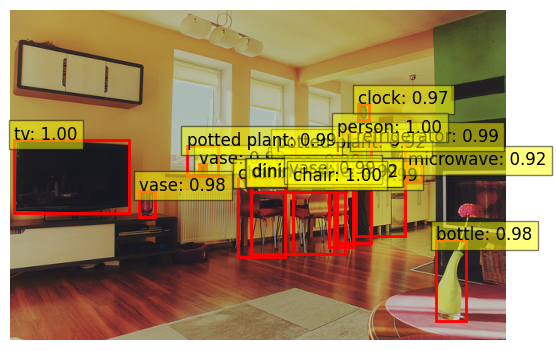

In [9]:
# Load first image in the validation dataset
image_path = "val2017/000000000139.jpg"
image = Image.open(image_path).convert("RGB")

# Preprocess and move to device
inputs = processor(images=image, return_tensors="pt").to(device)

plt.imshow(image)

# Run inference
with torch.no_grad():
    outputs = model(**inputs)

# Postprocess results
target_sizes = torch.tensor([image.size[::-1]], device=device)
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

# Visualize
plt.imshow(image)
ax = plt.gca()

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    xmin, ymin, xmax, ymax = box.tolist()
    ax.add_patch(patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='red', linewidth=2))
    label_text = f"{model.config.id2label[label.item()]}: {score.item():.2f}"
    ax.text(xmin, ymin, label_text, fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

plt.axis("off")
plt.show()

In [14]:
results = []
print("Running inference on images...")
for image_file in tqdm(image_files):
    image_id = int(image_file.split(".")[0])
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path).convert("RGB")

    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    # Get target size for post-processing
    target_sizes = torch.tensor([image.size[::-1]], device=device)
    output = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

    # Convert to COCO format
    for score, label, box in zip(output["scores"], output["labels"], output["boxes"]):
        xmin, ymin, xmax, ymax = box.tolist()
        width = xmax - xmin
        height = ymax - ymin
        results.append({
            "image_id": image_id,
            "category_id": model.config.id2label[label.item()],
            "bbox": [xmin, ymin, width, height],
            "score": score.item()
        })

Running inference on images...


100%|██████████| 5000/5000 [11:48<00:00,  7.06it/s]


In [15]:
# Convert category names to COCO category IDs

label_to_coco_id = {cat['name']: cat['id'] for cat in coco.loadCats(coco.getCatIds())}
for r in results:
    r['category_id'] = label_to_coco_id.get(r['category_id'], 0)

# Save results
with open("detr_coco_results.json", "w") as f:
    json.dump(results, f)

# Evaluate mAP and IOU with pycocotools
coco_dt = coco.loadRes("detr_coco_results.json")
coco_eval = COCOeval(coco, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=15.70s).
Accumulating evaluation results...
DONE (t=1.73s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.523
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.159
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.421
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1